In [20]:

from matplotlib import pyplot as plt
import os
import numpy as np
import glob
import os

## astropy
import astropy.units as u
from astropy.table import Table

## calin
from cta.nectarcam.feb.I_NmcConfig import NmcConfig

## ctapipe
from ctapipe_io_nectarcam import NectarCAMEventSource 
from ctapipe.io import event_source, EventSeeker

import scipy.stats as scsp
from scipy.stats import poisson                                                                                                             

from fit_ses_v6 import *
#import seaborn as sns


plt.rcParams['figure.figsize'] = [15, 7]

In [2]:
        MC_file_path = '/media/ttaverni/Transcend/MC_s/Heide/test_ff-1kevents-30pe.simtel.gz'
        
        inputfile_reader_MC = event_source(
            input_url = MC_file_path,
            max_events=1000)

        all_wfs = []
        for ii, event in enumerate(inputfile_reader_MC):
            all_wfs.append(event.r0.tel[1].waveform[:,:])
        wfs_MC    = np.array(all_wfs)

In [3]:
        data_file_path = "/media/ttaverni/Transcend/data/scans_08019/NectarCAM.Run1555.000[0-9].fits.fz"
        
        inputfile_reader = NectarCAMEventSource(
            input_url = data_file_path,
            max_events=50000)

        cfg = inputfile_reader.camera_config
        pix_ids = cfg.expected_pixels_id[:]
        all_wfs = []
        for ii, event in enumerate(inputfile_reader):
            Qm = (event.r0.tel[event.r0.tels_with_data[0]].waveform[0,pix_ids,:]-250.).sum(axis=1).mean()/58.
            if Qm >15 and Qm<35:
                all_wfs.append(event.r0.tel[event.r0.tels_with_data[0]].waveform[:,pix_ids])
                if len(all_wfs)>1000:
                    break
        wfs_data = np.array(all_wfs)

In [4]:
all_wfs=[]

In [29]:
maxs_MC = wfs_MC.argmax(axis=3).flatten()
maxs_data = wfs_data.argmax(axis=3).flatten()
print(maxs.min())
print(maxs.max())

0
63


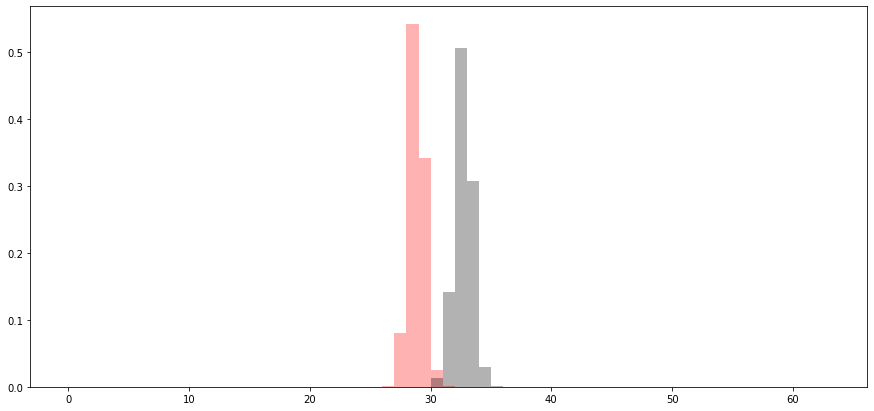

In [31]:
h = plt.hist(maxs_MC,  bins=np.arange(0,64),density=1,alpha=.3,color='red')
h = plt.hist(maxs_data,bins=np.arange(0,64),density=1,alpha=.3,color='black')

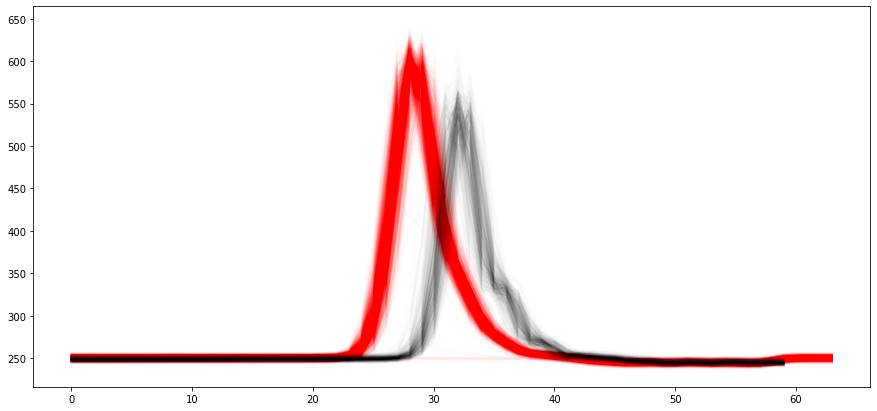

In [24]:
wfs_means_MC = wfs_MC[:,0].mean(axis=0)
wfs_means_data = wfs_data[:,0].mean(axis=0)

p = plt.plot(wfs_means_MC.T,alpha=.01,color='red')
p = plt.plot(wfs_means_data.T,alpha=.01,color='black')

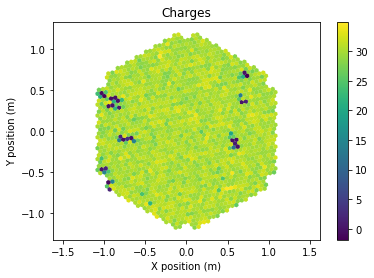

In [8]:

geom = CameraGeometry.from_name("NectarCam-002")

Qs = (wfs_means_MC[:,20:40]-250).sum(axis=1)/58.
Qs_data = (wfs_means_data[:,25:45]-250).sum(axis=1)/58.

disp1 = CameraDisplay(geom,title='Charges')
disp1.add_colorbar()
disp1.image = Qs

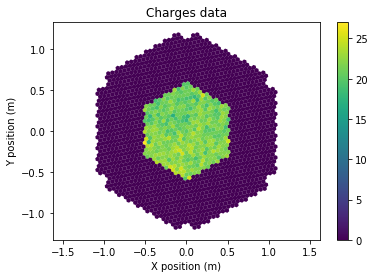

In [9]:
disp1 = CameraDisplay(geom,title='Charges data')
disp1.add_colorbar()
img = np.arange(1855)*0
img[pix_ids] = Qs_data
disp1.image = img

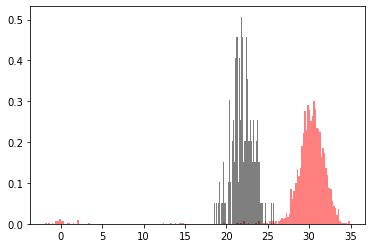

In [10]:
h = plt.hist(Qs,100,color='red',alpha=.5,density=1)
h = plt.hist(Qs_data,100,color='black',alpha=.5,density=1)

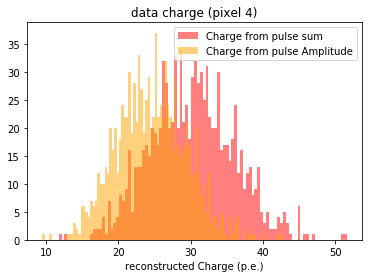

In [11]:
pix = 4
h= plt.hist((wfs_MC[:,0,pix,20:40]-250.).sum(axis=1)/58.,100,color='red',alpha=.5,\
           label= "Charge from pulse sum")
h= plt.hist((wfs_MC[:,0,pix,:]-250.).max(axis=1)/14.,100,color='orange',alpha=.5,\
           label= "Charge from pulse Amplitude")

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('reconstructed Charge (p.e.)')
l = plt.gca().legend()


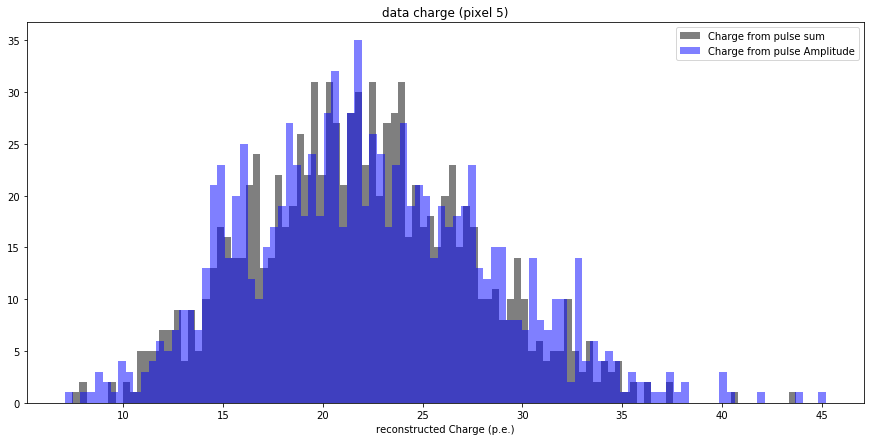

In [25]:
pix = 5
h= plt.hist((wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.,100,color='black',alpha=.5,\
           label= "Charge from pulse sum")
h= plt.hist((wfs_data[:,0,pix,:]-250.).max(axis=1)/14.,100,color='blue',alpha=.5,\
           label= "Charge from pulse Amplitude")

t = plt.gca().set_title('data charge (pixel {})'.format(pix))
t = plt.gca().set_xlabel('reconstructed Charge (p.e.)')
l = plt.gca().legend()


In [13]:
from cta.MyNectar.scripts.Nectarpipe.MakePTemplate import * 

In [14]:
QAmp = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
pixs=[0,1]
fct_dat,tmax_dat,shft_dat,Tstd_dat = GetSyncSpePulseShape(wfs_data,500,4,0,pixs,ManualShift = 0,QAmp = 14.)

barymax :  [30. 30. 30. 30. 30. 30. 30.]
T_0 : 30.25 ns
shft 1.772081839970767
Tstd ::  0.4868715911951012


In [15]:
QAmp_MC = np.mean( (wfs_data[:,0,pix,20:40]-250.).sum(axis=1)/58.)
fct_mc,tmax_mc,shft_mc,Tstd_mc = GetSyncSpePulseShape(wfs_MC,500,4,0,pixs,ManualShift = 0,QAmp = 14.)

barymax :  [30. 30. 30. 30. 30. 30. 30.]
T_0 : 30.25 ns
shft -2.1259425640727154
Tstd ::  0.5019035199240925


Text(0.5, 1.0, 'pulse shape')

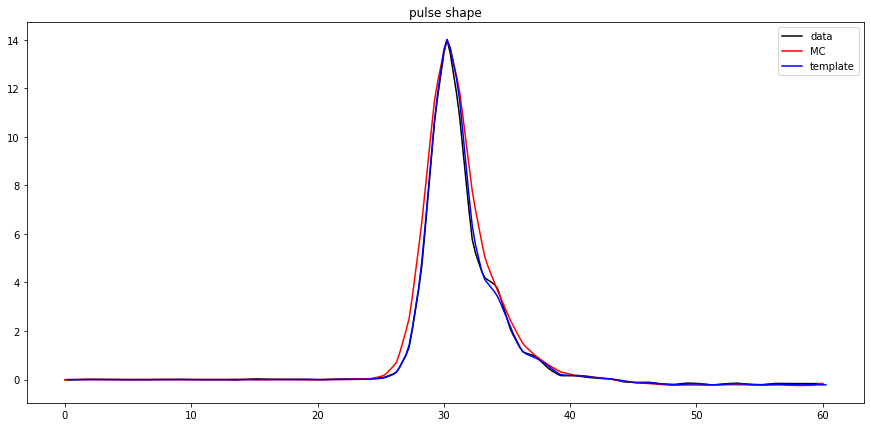

In [35]:
ff2 ="./Pulse_template_nectarCam_22112018.dat"
f= open(ff2,'r')
sss =[]
p_template=[]
for line in f.readlines():
    al = np.array(line.split(),dtype=np.float)
    if len(al)>2:  
        sss.append(al[0])
        p_template.append(al[1])

        
ss = np.arange(60)
plt.plot(sss,fct_dat(sss+shft_dat),color='black',label="data")
plt.plot(sss,fct_mc(sss+shft_mc),color='red',label='MC')
plt.plot(np.array(sss)+0.25,p_template,color='blue',label="template")
l = plt.gca().legend()
plt.gca().set_title('pulse shape')

In [17]:
fct_mc(ss+shft_mc).sum()

66.77854124672938

In [18]:
fct_dat(ss+shft_dat).sum()

58.22377138787882

In [19]:
np.array(p_template)[1::4].sum()

59.063621674